In [1]:
############
# PACKAGES #
############

%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
theano.config.exception_verbosity='high'
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import cPickle as pickle
import gzip
import os
import sys
import timeit

import cartpole_lib as cp

import nnet_lib as nnet


# An example of a simple policy for a single cart/pole mass

In [2]:
#################
# GENERATE DATA #
#################

dt, eps = 0.1, 0.1
Q = np.eye(6)
R = np.eye(1)

xref1 = np.array([0,np.pi,0,0,10,1])
uref = 0.
A1, B1, c1 = cp.linearize_cartpole_ext(xref1, uref, dt, eps)
K1, P1, Quu1 = cp.lqr_infinite_horizon(A1, B1, Q, R)

x1 = np.array([0, np.pi - np.pi/4, 0, 0, 10, 1])
x2 = np.array([0, np.pi + np.pi/4, 0, 0, 10, 1])

tr_x, tr_u, val_x, val_u, te_x, te_u = cp.gen_train_data([x1, x2], [K1, K1], [Quu1, Quu1], 
                                                         num_traj=20, traj_size=500)

In [5]:
####################
# TRAIN BASIC NNET #
####################

input1, policy1, tr_loss1, val_loss1, test_loss1 = nnet.train_NN(
    tr_x, tr_u, val_x, val_u, te_x, te_u, # Training, validiation, and test data
    n_layers=1, n_hidden=15, # Nnet parameters
    learning_rule='adagrad', learning_rate=1.0, L1_reg=0.0, L2_reg=0.00001, batch_size=50, rho=0.9, #SGD parameters
    n_epochs=100, print_interval=5, random_order=True # Training parameters
)

... building the model
... training
epoch 5, minibatch 400/400, validation error 127.958575, test error of best model 129.507264
epoch 10, minibatch 400/400, validation error 64.582250, test error of best model 72.329509
epoch 15, minibatch 400/400, validation error 33.955927, test error of best model 46.711924
epoch 20, minibatch 400/400, validation error 20.953326, test error of best model 37.406107
epoch 25, minibatch 400/400, validation error 14.629256, test error of best model 33.606638
epoch 30, minibatch 400/400, validation error 9.825600, test error of best model 30.656134
epoch 35, minibatch 400/400, validation error 7.074868, test error of best model 29.258375
epoch 40, minibatch 400/400, validation error 5.555635, test error of best model 28.732040
epoch 45, minibatch 400/400, validation error 4.879729, test error of best model 28.800007
epoch 50, minibatch 400/400, validation error 4.558733, test error of best model 28.996947
epoch 55, minibatch 400/400, validation error 4.

Final position for starting position x1
[ -5.69449810e-01   3.14159372e+00   2.18385025e-04   1.56782291e-06
   1.00000000e+01   1.00000000e+00]
Final position for starting position x2
[ -5.67820686e-01   3.14159191e+00  -1.86060296e-04  -1.40475271e-06
   1.00000000e+01   1.00000000e+00]


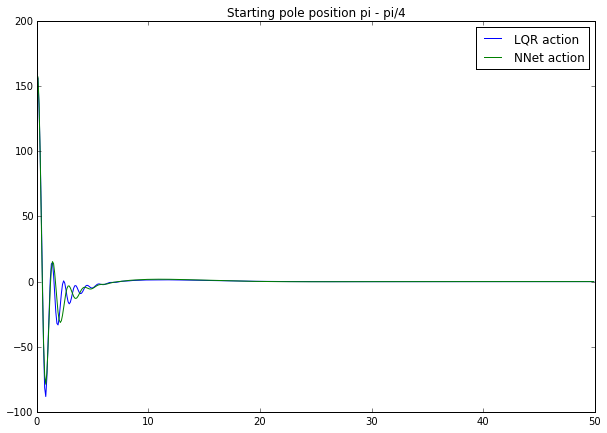

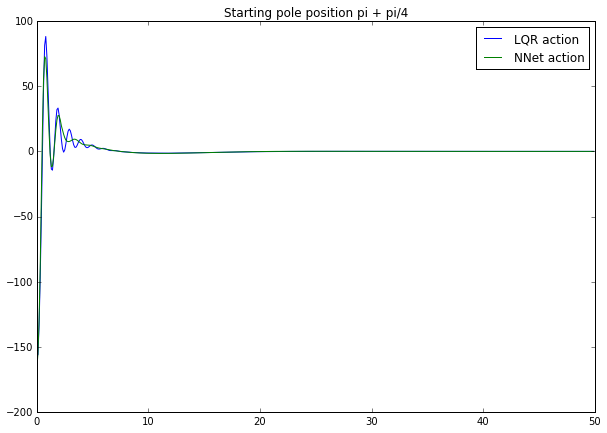

In [6]:
####################
# TEST NNET POLICY #
####################

feed_forward = theano.function(
    inputs=[input1],
    outputs=policy1.output)

x_ref = np.array([0, np.pi, 0, 0, 10, 1])

# First starting position
x_sim1 = np.zeros([6,500])
x_sim1[:,0] = x1

u_sim1 = np.zeros([500,])
u_sim1[0] = feed_forward(x_sim1[:,0].reshape([1,6]))

for t in range(499):
    x_sim1[:,t+1] = cp.sim_cartpole_ext(x_sim1[:,t], u_sim1[t], dt)
    u_sim1[t+1] = feed_forward(x_sim1[:,t+1].reshape([1,6]))

x_lqr1 = np.zeros([6,500])
x_lqr1[:,0] = x1

u_lqr1 = np.zeros([500,])
u_lqr1[0] = np.dot(K1, x_lqr1[:,0] - x_ref)
for t in range(499):
    x_lqr1[:,t+1] = cp.sim_cartpole_ext(x_lqr1[:,t], u_lqr1[t], dt)
    u_lqr1[t+1] = np.dot(K1, x_lqr1[:,t] - x_ref)

# Second starting position
x_sim2 = np.zeros([6,500])
x_sim2[:,0] = x2

u_sim2 = np.zeros([500,])
u_sim2[0] = feed_forward(x_sim2[:,0].reshape([1,6]))

for t in range(499):
    x_sim2[:,t+1] = cp.sim_cartpole_ext(x_sim2[:,t], u_sim2[t], dt)
    u_sim2[t+1] = feed_forward(x_sim2[:,t+1].reshape([1,6]))

x_lqr2 = np.zeros([6,500])
x_lqr2[:,0] = x2

u_lqr2 = np.zeros([500,])
u_lqr2[0] = np.dot(K1, x_lqr2[:,0] - x_ref)
for t in range(499):
    x_lqr2[:,t+1] = cp.sim_cartpole_ext(x_lqr2[:,t], u_lqr2[t], dt)
    u_lqr2[t+1] = np.dot(K1, x_lqr2[:,t] - x_ref)
    
tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr1.flatten(), label="LQR action")
plt.plot(tt, u_sim1.flatten(), label="NNet action")
plt.title("Starting pole position pi - pi/4")
plt.legend()

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr2.flatten(), label="LQR action")
plt.plot(tt, u_sim2.flatten(), label="NNet action")
plt.title("Starting pole position pi + pi/4")
plt.legend()

print "Final position for starting position x1"
print x_sim1[:,-1]
print "Final position for starting position x2"
print x_sim2[:,-1]

# A Simple policy that is able to generalize

In [13]:
xref2 = np.array([0,np.pi,0,0,5,0.5])
A2, B2, c2 = cp.linearize_cartpole_ext(xref2, uref, dt, eps)
K2, P2, Quu2 = cp.lqr_infinite_horizon(A2, B2, Q, R)

xref2 = np.array([0,np.pi,0,0,7.5,0.75])
A3, B3, c3 = cp.linearize_cartpole_ext(xref2, uref, dt, eps)
K3, P3, Quu3 = cp.lqr_infinite_horizon(A3, B3, Q, R)

x3 = np.array([0, np.pi - np.pi/4, 0, 0, 5, 0.5])
x4 = np.array([0, np.pi + np.pi/4, 0, 0, 5, 0.5])

x5 = np.array([0, np.pi - np.pi/4, 0, 0, 7.5, 0.75])
x6 = np.array([0, np.pi + np.pi/4, 0, 0, 7.5, 0.75])

tr_x, tr_u, val_x, val_u, te_x, te_u = cp.gen_train_data(
    [x1, x2, x3, x4, x5, x6], 
    [K1, K1, K2, K2, K3, K3], 
    [Quu1, Quu1, Quu2, Quu2, Quu3, Quu3], 
    num_traj=20, traj_size=500)


In [25]:
####################
# TRAIN BASIC NNET #
####################

input2, policy2, tr_loss2, val_loss2, test_loss2 = nnet.train_NN(
    tr_x, tr_u, val_x, val_u, te_x, te_u, # Training, validiation, and test data
    n_layers=1, n_hidden=25, # Nnet parameters
    learning_rule='adagrad', learning_rate=1.0, L1_reg=0.0, L2_reg=0.0000005, batch_size=20, rho=0.9, #SGD parameters
    n_epochs=100, print_interval=10, random_order=True # Training parameters
)


... building the model
... training
epoch 10, minibatch 3000/3000, validation error 17.440160, test error of best model 36.338096
epoch 20, minibatch 3000/3000, validation error 7.780052, test error of best model 35.375744
epoch 30, minibatch 3000/3000, validation error 5.613957, test error of best model 34.882340
epoch 40, minibatch 3000/3000, validation error 5.025459, test error of best model 35.182946
epoch 50, minibatch 3000/3000, validation error 4.632356, test error of best model 34.688787
epoch 60, minibatch 3000/3000, validation error 4.118613, test error of best model 35.581873
epoch 70, minibatch 3000/3000, validation error 3.858899, test error of best model 35.550113
epoch 80, minibatch 3000/3000, validation error 3.730157, test error of best model 35.807633
epoch 90, minibatch 3000/3000, validation error 3.650457, test error of best model 35.979776
epoch 100, minibatch 3000/3000, validation error 3.591885, test error of best model 36.073714
Optimization complete. Best vali

3.83688540707


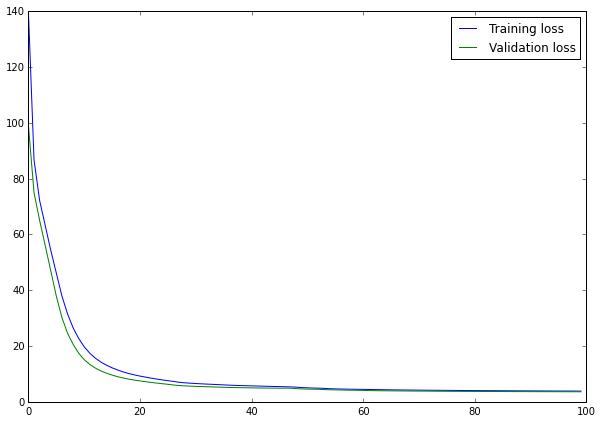

In [26]:
plt.figure(figsize=(10,7))
plt.plot(tr_loss2, label="Training loss")
plt.plot(val_loss2, label="Validation loss")
plt.legend()
print np.min(tr_loss2)


Final position for starting position x1
[ -3.05276541e-02   3.14159823e+00   2.50545267e-04   1.87243865e-07
   1.00000000e+01   1.00000000e+00]
Final position for starting position x2
[  1.55979626e-01   3.14159497e+00  -1.93002308e-05  -2.63554345e-05
   5.00000000e+00   5.00000000e-01]
Final position for test starting position
[ -6.96309730e-01   3.14159314e+00   1.07397480e-05  -1.15095418e-07
   1.20000000e+01   1.20000000e+00]


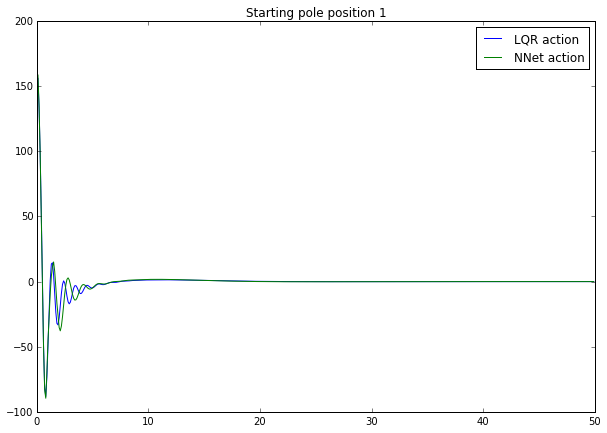

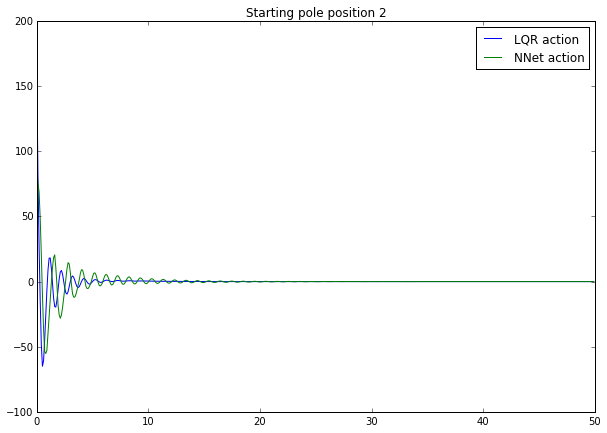

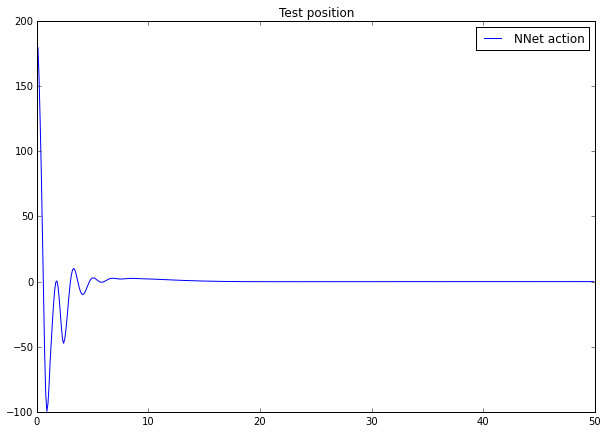

In [36]:
##########################
# TEST THE POLICY POLICY #
##########################

feed_forward = theano.function(
    inputs=[input2],
    outputs=policy2.output)

x_ref1 = np.array([0, np.pi, 0, 0, 10, 1])
x_ref2 = np.array([0, np.pi, 0, 0, 5, 0.5])

# First starting position
x_sim1 = np.zeros([6,500])
x_sim1[:,0] = x1

u_sim1 = np.zeros([500,])
u_sim1[0] = feed_forward(x_sim1[:,0].reshape([1,6]))

for t in range(499):
    x_sim1[:,t+1] = cp.sim_cartpole_ext(x_sim1[:,t], u_sim1[t], dt)
    u_sim1[t+1] = feed_forward(x_sim1[:,t+1].reshape([1,6]))

x_lqr1 = np.zeros([6,500])
x_lqr1[:,0] = x1

u_lqr1 = np.zeros([500,])
u_lqr1[0] = np.dot(K1, x_lqr1[:,0] - x_ref)
for t in range(499):
    x_lqr1[:,t+1] = cp.sim_cartpole_ext(x_lqr1[:,t], u_lqr1[t], dt)
    u_lqr1[t+1] = np.dot(K1, x_lqr1[:,t] - x_ref)

# Second starting position
x_sim2 = np.zeros([6,500])
x_sim2[:,0] = x3

u_sim2 = np.zeros([500,])
u_sim2[0] = feed_forward(x_sim2[:,0].reshape([1,6]))

for t in range(499):
    x_sim2[:,t+1] = cp.sim_cartpole_ext(x_sim2[:,t], u_sim2[t], dt)
    u_sim2[t+1] = feed_forward(x_sim2[:,t+1].reshape([1,6]))

x_lqr2 = np.zeros([6,500])
x_lqr2[:,0] = x3

u_lqr2 = np.zeros([500,])
u_lqr2[0] = np.dot(K1, x_lqr2[:,0] - x_ref2)
for t in range(499):
    x_lqr2[:,t+1] = cp.sim_cartpole_ext(x_lqr2[:,t], u_lqr2[t], dt)
    u_lqr2[t+1] = np.dot(K2, x_lqr2[:,t] - x_ref2)

# Second starting position
x_sim3 = np.zeros([6,500])
x_sim3[:,0] = np.array([0, np.pi - np.pi/4, 0, 0, 12, 1.2])

u_sim3 = np.zeros([500,])
u_sim3[0] = feed_forward(x_sim3[:,0].reshape([1,6]))

for t in range(499):
    x_sim3[:,t+1] = cp.sim_cartpole_ext(x_sim3[:,t], u_sim3[t], dt)
    u_sim3[t+1] = feed_forward(x_sim3[:,t+1].reshape([1,6]))

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr1.flatten(), label="LQR action")
plt.plot(tt, u_sim1.flatten(), label="NNet action")
plt.title("Starting pole position 1")
plt.legend()

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_lqr2.flatten(), label="LQR action")
plt.plot(tt, u_sim2.flatten(), label="NNet action")
plt.title("Starting pole position 2")
plt.legend()

tt = dt*np.arange(0,500)
plt.figure(figsize=(10,7))
plt.plot(tt, u_sim3.flatten(), label="NNet action")
plt.title("Test position")
plt.legend()

print "Final position for starting position x1"
print x_sim1[:,-1]
print "Final position for starting position x2"
print x_sim2[:,-1]
print "Final position for test starting position"
print x_sim3[:,-1]
